# Simulation of Complex Systems - Chapter 6
Artur Gasparyan

## Exercise 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import constants

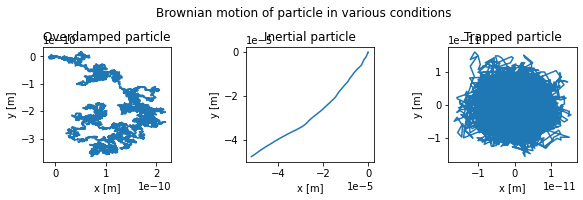

In [119]:
rng = np.random.default_rng()
n_steps = 10000
n_steps_long = 20000
n_simulations = 100
time_step = 0.001

temperature = 300
gamma = 1.3
tau = 3E-5
k_stiff = 100

def calculate_trajectories_overdamped(n_simulations, n_steps):
    trajectories = np.zeros((n_simulations, n_steps, 2))
    fluctations = rng.normal(size=(n_simulations, n_steps, 2))/math.sqrt(2)   # Random 2D steps scaled to length w_i
    factor = math.sqrt(2*constants.Boltzmann*temperature*time_step/gamma)
    
    for i in range(1, n_steps):
        trajectories[:, i, :] = trajectories[:, i-1, :] + factor * fluctations[:, i, :]
        
    return trajectories

def calculate_trajectories_inertial(n_simulations, n_steps):
    trajectories = np.zeros((n_simulations, n_steps, 2))
    fluctations = rng.normal(size=(n_simulations, n_steps, 2))/math.sqrt(2)   # Random 2D steps normalized to 1
    
    factor_1 = (2+time_step*tau) / (1+time_step*tau)
    factor_2 = -1/(1 + time_step * tau)
    factor_3 = math.sqrt(2*constants.Boltzmann*temperature*gamma) / (tau*gamma*(1+time_step*tau)) * time_step**1.5
                        
    for i in range(1, n_steps):
        trajectories[:, i, :] = (
            factor_1 * trajectories[:, i-1, :] +
            factor_2 * trajectories[:, i-2, :] +
            factor_3 * fluctations[:, i, :]
        )
    
    return trajectories


def calculate_trajectories_trapped(n_simulations, n_steps):
    trajectories = np.zeros((n_simulations, n_steps, 2))
    fluctations = rng.normal(size=(n_simulations, n_steps, 2))/math.sqrt(2)   # Random 2D steps normalized to 1
    
    factor_1 = 1 - k_stiff/gamma*time_step
    factor_2 = math.sqrt(2*constants.Boltzmann*temperature*time_step/gamma)
    
    for i in range(1, n_steps):
        trajectories[:, i, :] = factor_1 * trajectories[:, i-1, :] + factor_2 * fluctations[:, i, :]
        
    return trajectories
    
x_overdamped = calculate_trajectories_overdamped(n_simulations, n_steps)
x_overdamped_long = calculate_trajectories_overdamped(1, )
x_inertial = calculate_trajectories_inertial(n_simulations, n_steps)
x_trapped = calculate_trajectories_trapped(n_simulations, n_steps)
    
x_all = [x_overdamped, x_inertial, x_trapped]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
fig.tight_layout(pad=4)
fig.suptitle("Brownian motion of particle in various conditions")
titles = ["Overdamped particle", "Inertial particle", "Trapped particle"]

for x, ax, title in zip(x_all, axes, titles):
    ax.plot(x[0, :, 0], x[0, :, 1])
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(title)

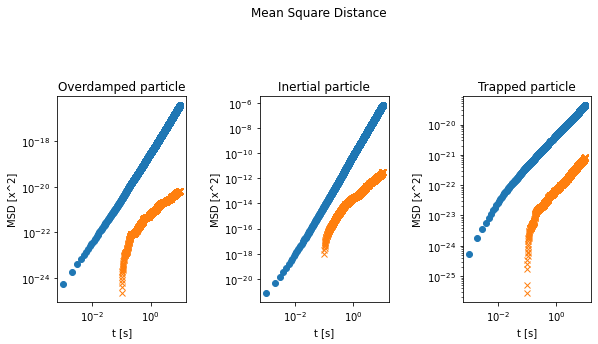

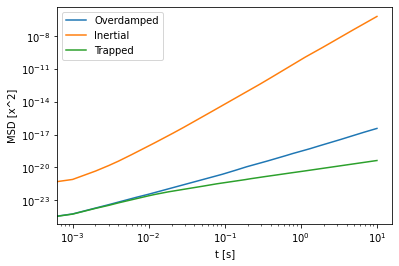

In [152]:
def get_metrics_from_x(x, n_steps):
    sqr_dist = np.linalg.norm(x, axis=2)**2  # x0 is always (0, 0)
    msd = np.cumsum(sqr_dist, axis=1)
    emsd = np.mean(msd, axis=0) / (n_steps*time_step)
    
    # https://physics.stackexchange.com/a/438200
    # OBSERVE: DOES NOT WORK
    n = 100
    trail = x[1, :, :]
    sqr_dist_t = np.linalg.norm(trail[n:]-trail[:-n], axis=1)**2
    tmsd = np.cumsum(sqr_dist_t) / (n_steps*(n+1)*time_step) 
    
    return {"sqr_dist": sqr_dist, "msd": msd, "emsd": emsd, "tmsd": tmsd}

metrics_overdamped = get_metrics_from_x(x_overdamped, n_steps)
metrics_inertial = get_metrics_from_x(x_inertial, n_steps)
metrics_trapped = get_metrics_from_x(x_trapped, n_steps)
metrics_all = [metrics_overdamped, metrics_inertial, metrics_trapped]
titles = ["Overdamped particle", "Inertial particle", "Trapped particle"]

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle("Mean Square Distance")
fig.tight_layout(pad=4)

t = np.arange(n_steps)*time_step
for metric, ax, title in zip(metrics_all, axes, titles):
    ax.plot(t, metric["emsd"], 'o')
    ax.plot(t[100:], metric["tmsd"], 'x')  # TODO: FIX THIS
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("t [s]")
    ax.set_ylabel("MSD [x^2]")

    
fig = plt.figure()
plt.plot(t, metrics_overdamped["emsd"])
plt.plot(t, metrics_inertial["emsd"])
plt.plot(t, metrics_trapped["emsd"])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel('MSD [x^2]')
plt.legend(["Overdamped", "Inertial", "Trapped"]);
